## 1. Understanding the Business Problem
The objective of this assignment is to analyze the effectiveness of various marketing campaigns conducted by a Portuguese banking institution. The primary business problem is to predict whether clients will subscribe to a term deposit based on the results of multiple telemarketing efforts. Understanding this prediction is crucial for the bank as it directly impacts their marketing strategies and customer engagement.

By identifying the characteristics of clients most likely to accept the offer, the bank can optimize its marketing efforts, allocate resources more effectively, and tailor communications to specific customer segments. This approach not only enhances customer satisfaction through personalized offerings but also increases the overall profitability of the bank by reducing wasted marketing expenditures.

In summary, solving this problem will enable the bank to make data-driven decisions that improve the targeting of potential clients, ultimately leading to higher conversion rates in their marketing campaigns.

## 2. Data Understanding and Preparation

In [221]:
import pandas as pd

In [223]:
df = pd.read_csv('https://raw.githubusercontent.com/JaFaSch/Jan-Schreder-assignment-17.1/refs/heads/main/bank-additional-full.csv', sep=';')

In [224]:
# Drops the specified columns from the DataFrame because they are not relevant to the analysis. axis=1 means dropping columns (not rows).
df = df.drop(['contact','month','day_of_week','duration','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed'], axis=1)

In [225]:
# Removes all rows from the DataFrame where any of the columns contain missing (NaN) values
df = df.dropna()

In [226]:
# Filters out rows where any column contains the string 'unknown'. This line converts each row to strings, checks for the 'unknown' value, and excludes those rows from df.
df = df[~df.apply(lambda row: row.astype(str).str.contains('unknown').any(), axis=1)]

In [227]:
# Identify binary columns (object type with exactly two unique values)
binary_columns = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() == 2]

# Map binary values to 0 and 1
binary_mapping = {'yes': 1, 'no': 0}
for column in binary_columns:
    df[column] = df[column].map(binary_mapping)
    

In [228]:
from sklearn.preprocessing import OneHotEncoder
# Identify remaining object columns for one-hot encoding
object_columns = df.select_dtypes(include=['object']).columns

# Apply OneHotEncoder to object columns
encoder = OneHotEncoder(sparse_output=False, drop=None)
encoded_data = encoder.fit_transform(df[object_columns])

# Create a DataFrame with the encoded columns
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(object_columns))
# Reset index of both DataFrames to ensure alignment
df = df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Drop the original object columns and concatenate the encoded columns
df = df.drop(object_columns, axis=1)
df = pd.concat([df, encoded_df], axis=1)

In [229]:
from sklearn.model_selection import train_test_split, GridSearchCV
# Separate features and target variable. Set test size to 30%
X = df.drop('y', axis=1)
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [230]:
#Display the dimensions of the training and testing sets, ensuring the split was successful
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (21341, 31)
X_test shape: (9147, 31)
y_train shape: (21341,)
y_test shape: (9147,)


## 3. Modeling

In [231]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, Normalizer
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV


***K-Nearest Neighbors (KNN):***
What it does: Classifies a data point based on the majority class among its k-nearest neighbors in the feature space.
Typical use case: Used for classification tasks with small to medium-sized datasets where the decision boundary is not complex.

***Logistic Regression:***
What it does: Predicts the probability of a binary outcome using a logistic function, often used for binary classification tasks.
Typical use case: Used for binary classification problems, especially when the relationship between the features and the target is linear.

***Decision Tree:***
What it does: Splits the data into subsets based on feature values, creating a tree-like model of decisions to classify data points.
Typical use case: Used for both classification and regression tasks, especially when interpretability and handling of non-linear relationships are important.

***Support Vector Machine (SVM):***
What it does: Finds the optimal hyperplane that maximizes the margin between different classes in the feature space for classification tasks.
Typical use case: Used for classification tasks with high-dimensional data and when the decision boundary is complex and non-linear.

In [232]:
# Set up pipelines for three different classifiers (KNN, Logistic Regression, and Decision Tree), each including data scaling with StandardScaler and the respective model.
pipelines = {
    'knn': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    'log_reg': Pipeline([('scaler', StandardScaler()), ('log_reg', LogisticRegression(max_iter=1000))]),
    'decision_tree': Pipeline([('scaler', StandardScaler()), ('decision_tree', DecisionTreeClassifier())]),
}

In [233]:
# Set up pipline for SVM in separate variable due to GridSearchCV can't be used due to very long fitting times. For SVM HalvingRandomSearchCV will be used to reduce fitting time
pipeline_svm = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

In [234]:
# Define hyperparameter grids for KNN, Logistic Regression, and Decision Tree classifiers. These grids will be used in GridSearchCV to find the optimal model configurations.
param_grids = {
    'knn': {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), Normalizer()],
        'knn__n_neighbors': [3, 5, 7],
        'knn__weights': ['uniform', 'distance']
    },
    'log_reg': {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), Normalizer()],
        'log_reg__C': [0.1, 1, 10],
        'log_reg__solver': ['liblinear', 'lbfgs']
    },
    'decision_tree': {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), Normalizer()],
        'decision_tree__max_depth': [None, 10, 20, 30],
        'decision_tree__min_samples_split': [2, 5, 10]
    },

}

In [235]:
# Specifies the parameter distributions for the SVM model, where C is sampled from a uniform distribution and other 
# hyperparameters like kernel type, degree, and gamma are specified for random search
from scipy.stats import uniform
param_distributions_svm = {
    'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), MaxAbsScaler(), Normalizer()],
    'svm__C': uniform(0.1, 10),  # Uniform distribution between 0.1 and 10
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Different kernels
    #'svm__degree': [2, 3, 4],  # Degree for polynomial kernel
    'svm__gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

In [236]:
import time
#Performs GridSearchCV on each pipeline to search for the best hyperparameters based on cross-validation. It stores the best models in the best_estimators dictionary.
best_estimators = {}
training_times = {}
for name, pipeline in pipelines.items():
    print(f"Starting GridSearchCV for {name}...")
    start_time = time.time()
    
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    best_estimators[name] = grid_search.best_estimator_
    training_times[name] = elapsed_time
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Training time for {name}: {elapsed_time:.2f} seconds")

# Find the fastest model
fastest_model = min(training_times, key=training_times.get)
print(f"\nThe fastest model is {fastest_model} with a training time of {training_times[fastest_model]:.2f} seconds")

Starting GridSearchCV for knn...
Best parameters for knn: {'knn__n_neighbors': 7, 'knn__weights': 'uniform', 'scaler': RobustScaler()}
Training time for knn: 16.53 seconds
Starting GridSearchCV for log_reg...
Best parameters for log_reg: {'log_reg__C': 0.1, 'log_reg__solver': 'lbfgs', 'scaler': RobustScaler()}
Training time for log_reg: 21.41 seconds
Starting GridSearchCV for decision_tree...
Best parameters for decision_tree: {'decision_tree__max_depth': 10, 'decision_tree__min_samples_split': 10, 'scaler': MaxAbsScaler()}
Training time for decision_tree: 15.61 seconds

The fastest model is decision_tree with a training time of 15.61 seconds


In [237]:
# Uses HalvingRandomSearchCV for efficient hyperparameter tuning of the SVM pipeline. This performs random sampling of hyperparameters, gradually focusing on the best ones.
# Measure the time for HalvingRandomSearchCV
start_time = time.time()

random_search = HalvingRandomSearchCV(pipeline_svm, param_distributions_svm, factor=3, cv=3, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
training_times['HalvingRandomSearchCV_SVM'] = elapsed_time
print(f"Training time for HalvingRandomSearchCV: {elapsed_time:.2f} seconds")


Training time for HalvingRandomSearchCV: 17.82 seconds


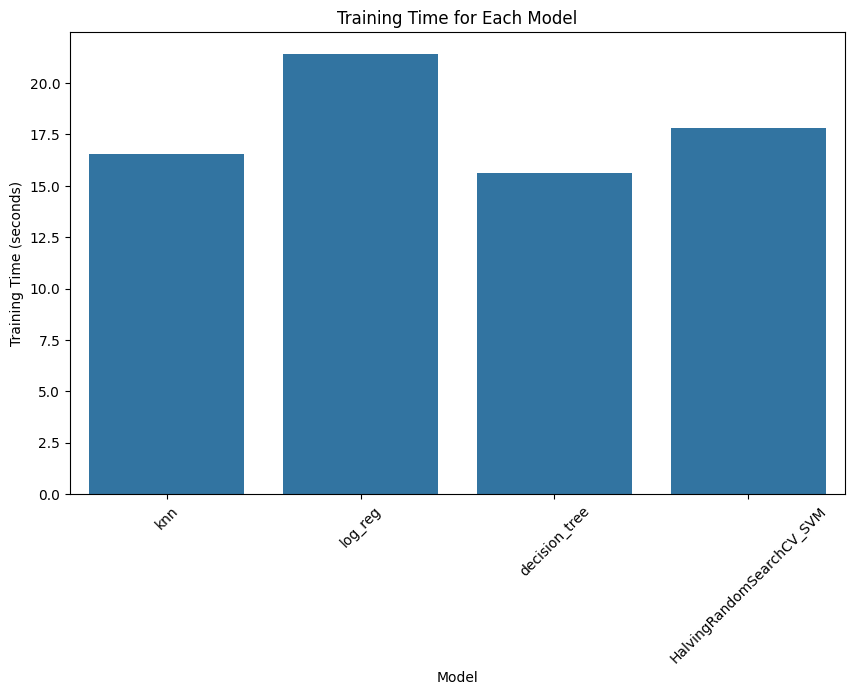

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for the training times
training_times_df = pd.DataFrame(list(training_times.items()), columns=['Model', 'Training Time'])

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training Time', data=training_times_df)
plt.title('Training Time for Each Model')
plt.ylabel('Training Time (seconds)')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

In [239]:
# Ensure best estimator for SVM found and add to best_estimators dictionary
best_estimators['svm'] = random_search.best_estimator_
print(f"Best parameters for SVM: {random_search.best_params_}")

Best parameters for SVM: {'scaler': MinMaxScaler(), 'svm__C': 3.525242571785434, 'svm__gamma': 'auto', 'svm__kernel': 'sigmoid'}


## 4. Evaluation

In [240]:
# Define a function to compute evaluation metrics (accuracy, precision, recall, F1 score) for a given model on the test set.
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def evaluate_performance_and_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, precision, recall, f1, cm

In [241]:
# Iterate over the best models, evaluates their performance on the test data using accuracy, precision, recall, and F1 score, and prints these metrics for each model.
for name, model in best_estimators.items():
    accuracy, precision, recall, f1, cm = evaluate_performance_and_confusion_matrix(model, X_test, y_test)
    print(f"Performance of {name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print(f"Confusion Matrix for {name}:\n{cm}")

Performance of knn:
  Accuracy: 0.8766
  Precision: 0.8483
  Recall: 0.8766
  F1 Score: 0.8494
Confusion Matrix for knn:
[[7793  181]
 [ 948  225]]
Performance of log_reg:
  Accuracy: 0.8830
  Precision: 0.8608
  Recall: 0.8830
  F1 Score: 0.8549
Confusion Matrix for log_reg:
[[7845  129]
 [ 941  232]]
Performance of decision_tree:
  Accuracy: 0.8797
  Precision: 0.8541
  Recall: 0.8797
  F1 Score: 0.8516
Confusion Matrix for decision_tree:
[[7823  151]
 [ 949  224]]
Performance of svm:
  Accuracy: 0.8830
  Precision: 0.8610
  Recall: 0.8830
  F1 Score: 0.8540
Confusion Matrix for svm:
[[7853  121]
 [ 949  224]]


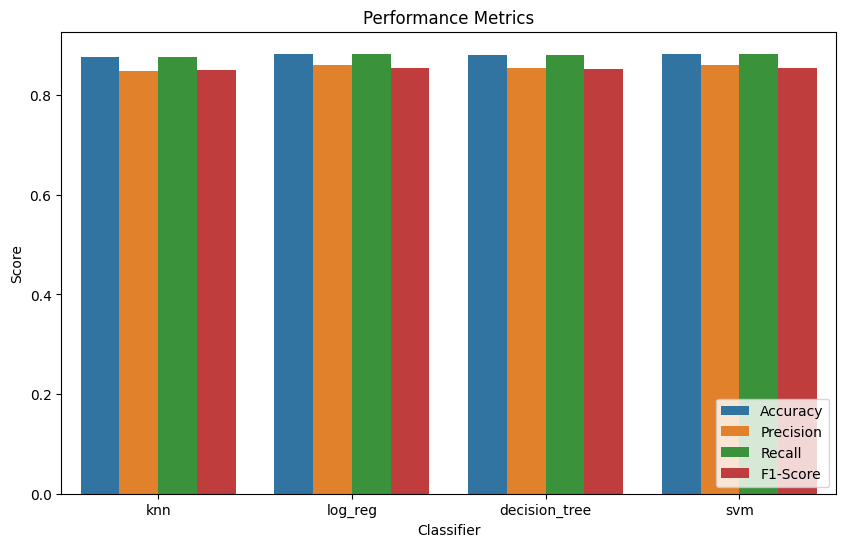

In [242]:
# Initialize an empty list to store performance data for each classifier
performance_data = []

# Loop through each classifier to evaluate performance and append metrics
for name, model in best_estimators.items():
    accuracy, precision, recall, f1, _ = evaluate_performance_and_confusion_matrix(model, X_test, y_test)
    performance_data.append([name, accuracy, precision, recall, f1])

# Create a DataFrame with the performance metrics
metrics_df = pd.DataFrame(performance_data, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

# Melt the DataFrame to long format for Seaborn
metrics_long_df = metrics_df.melt(id_vars='Classifier', var_name='Metric', value_name='Score')

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Classifier', y='Score', hue='Metric', data=metrics_long_df)
plt.title('Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


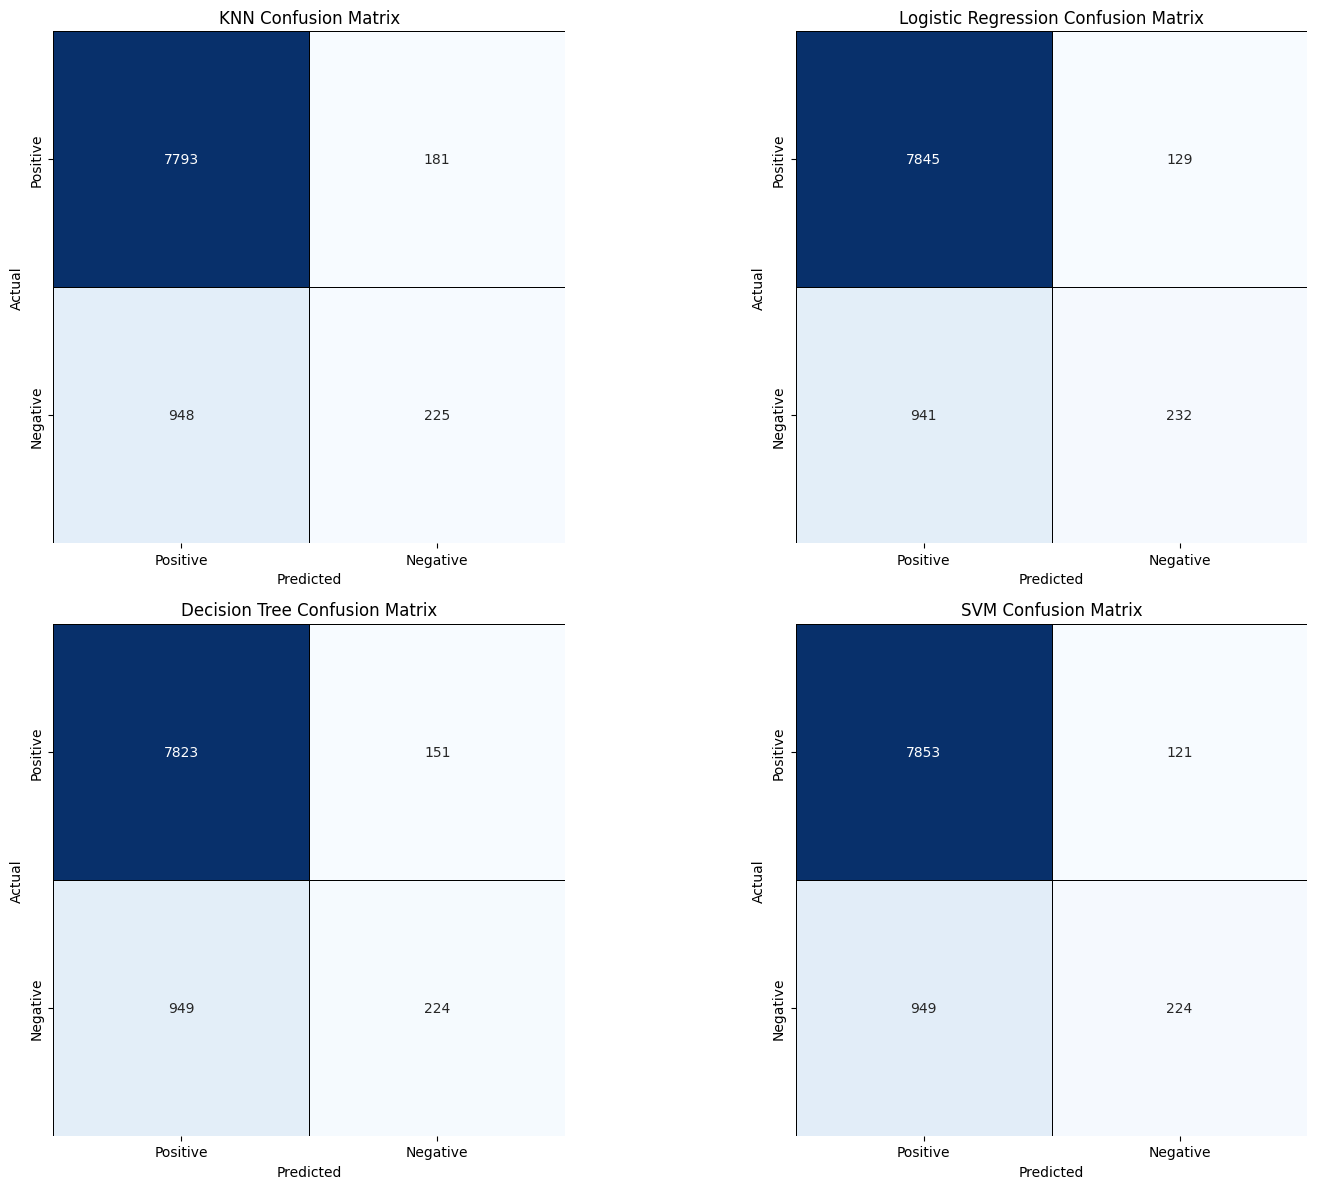

In [243]:
# Initialize the subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# List of model names for easy iteration
model_names = ['knn', 'log_reg', 'decision_tree', 'svm']
titles = ['KNN Confusion Matrix', 'Logistic Regression Confusion Matrix', 'Decision Tree Confusion Matrix', 'SVM Confusion Matrix']

# Iterate through models and plot confusion matrices
for i, (name, ax) in enumerate(zip(model_names, axes.flatten())):
    _, _, _, _, cm = evaluate_performance_and_confusion_matrix(best_estimators[name], X_test, y_test)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, cbar=False, linewidths=.5, linecolor='black', ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['Positive', 'Negative'])

plt.tight_layout()
plt.show()

In [244]:
# Find the best model based on F1 score
best_f1_model = metrics_df.loc[metrics_df['F1-Score'].idxmax()]
print("\nBest model based on F1 Score:")
print(best_f1_model)
# Find the best model based on Accuracy
best_accuracy_model = metrics_df.loc[metrics_df['Accuracy'].idxmax()]
print("\nBest model based on Accuracy:")
print(best_accuracy_model)
# Find the best model based on Precision
best_precision_model = metrics_df.loc[metrics_df['Precision'].idxmax()]
print("\nBest model based on Precision:")
print(best_precision_model)
# Find the best model based on Recall
best_recall_model = metrics_df.loc[metrics_df['Recall'].idxmax()]
print("\nBest model based on Recall:")
print(best_recall_model)


Best model based on F1 Score:
Classifier     log_reg
Accuracy      0.883022
Precision     0.860808
Recall        0.883022
F1-Score      0.854895
Name: 1, dtype: object

Best model based on Accuracy:
Classifier     log_reg
Accuracy      0.883022
Precision     0.860808
Recall        0.883022
F1-Score      0.854895
Name: 1, dtype: object

Best model based on Precision:
Classifier         svm
Accuracy      0.883022
Precision     0.861033
Recall        0.883022
F1-Score      0.854005
Name: 3, dtype: object

Best model based on Recall:
Classifier     log_reg
Accuracy      0.883022
Precision     0.860808
Recall        0.883022
F1-Score      0.854895
Name: 1, dtype: object


Logistic Regression Feature Importance:
                          Feature  Importance
15                    job_student    0.686575
12                    job_retired    0.640224
30               poutcome_success    0.438986
6                        previous    0.209319
20                 marital_single    0.196298
17                 job_unemployed    0.169096
27    education_university.degree    0.152569
25           education_illiterate    0.147649
0                             age    0.132548
3                            loan    0.020655
2                         housing    0.014456
26  education_professional.course    0.008931
7                      job_admin.    0.008101
5                           pdays   -0.001675
24          education_high.school   -0.009524
1                         default   -0.025193
19                marital_married   -0.036107
13              job_self-employed   -0.047617
21             education_basic.4y   -0.069983
22             education_basic.6y   -0.0

Text(0.5, 1.0, 'Logistic Regression Feature Importance')

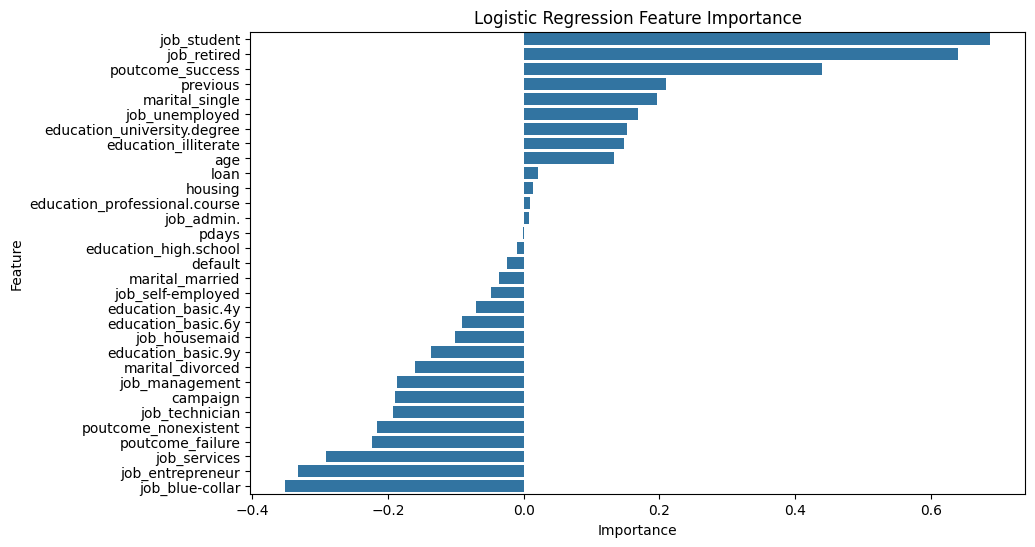

In [245]:
# Feature importance for logistic regression
log_reg_model = best_estimators['log_reg'].named_steps['log_reg']
log_reg_coefficients = log_reg_model.coef_[0]
log_reg_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': log_reg_coefficients
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance:")
print(log_reg_feature_importance)

# Plot feature importance for logistic regression
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=log_reg_feature_importance)
plt.title('Logistic Regression Feature Importance')


## 5. Deployment

### Findings
**Best Model:** The logistic regression model (log_reg) outperformed other classifiers (k-nearest neighbors, decision trees, and support vector machines) across all evaluated metrics besides Recall were it is tied with SVM.

**Consistency:** The logistic regression model consistently achieved the highest scores in all performance metrics, indicating its robustness and reliability for this dataset.

---

## Training Time
While the logistic regression model performed best in terms of metrics, it is also the slowest of them all. However, considering the differences are only a few seconds, this timing is negligible.

---

## Recommendations
**Deploy Logistic Regression:** Given its superior performance across all metrics, the logistic regression model should be considered for deployment in the marketing campaign prediction system.

---

## Monitor Model Performance
Continuously monitor the performance of the deployed model to ensure it maintains its accuracy and reliability over time. This can be done by periodically retraining the model with new data.

---

## Feature Importance

### Top Positive Features
- **job_student (0.686575):** Being a student has the highest positive impact.
- **job_retired (0.640224):** Being retired significantly increases the likelihood.
- **poutcome_success (0.438986):** A successful outcome in a previous campaign is a strong positive indicator.

### Top Negative Features
- **job_blue-collar (-0.350848):** Being a blue-collar worker significantly decreases the likelihood.
- **job_entrepreneur (-0.332510):** Being an entrepreneur has a strong negative impact.
- **job_services (-0.291301):** Working in services negatively impacts the likelihood.

### Recommendations Based on Feature Importance
- **Target Specific Job Categories:** Focus marketing efforts on students and retired individuals, as these groups are more likely to respond positively.
- **Leverage Previous Campaign Success:** Prioritize customers who had a successful outcome in previous campaigns, as they are more likely to respond positively again.
- **Address Negative Indicators:** Develop strategies to mitigate the negative impact of certain job categories like blue-collar workers, entrepreneurs, and service workers. For example, personalized follow-ups or special offers might help convert these customers.

---

## Scalability
Ensure that the logistic regression model can handle the scalability requirements of the marketing campaign, especially if the dataset grows significantly in size.
